# Programming Assignment #4: Recurrent Neural Networks
Author: Pierre Nugues

## Objectives

The objectives of this assignment are to:
* Write a program to recognize named entities in text
* Learn how to manage a text data set
* Apply recurrent neural networks to text
* Know what word embeddings are
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization and location

You can work alone or collaborate with another student:
* Each group will have to write Python programs to recognize named entities in text.
* You will have to experiment different architectures, namely RNN and LSTM, and compare the results you obtained.
* Each student will have to write an individual report on these experiments.

## Imports

In [2]:
import sys
import regex as re
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.activations import softmax

EPOCHS = 15
LSTM_UNITS = 100

## Collecting a Dataset

1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). In this assignment, you will work on the English dataset. Read the description of the task.
2. The datasets are protected by a license and you need to obtain it to reconstruct the data. Alternatively, you can try to find one on github (type conll2003 in the search box) or use the Google dataset search: <a href="https://toolbox.google.com/datasetsearch">https://toolbox.google.com/datasetsearch</a>. All this may take time and your teacher created a local copy in the `/usr/local/cs/EDAN95/datasets/NER-data` folder.
3. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

## Reading the Corpus

You will read the corpus with the cells below. The functions will enable you to load the files in the form of a list of dictionaries.

In [3]:
BASE_DIR = 'CoNLL2003/'

In [4]:
def load_conll2003_en():
    train_file = BASE_DIR + 'train.txt'
    dev_file = BASE_DIR + 'valid.txt'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [5]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- -X- O\n\nEU NNP B-NP B-ORG\nrejects VBZ B-VP O\nGerman JJ B-NP B-MISC\ncall NN I-NP O\nto T'

In [6]:
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [7]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [49]:
print(train_dict[1])
print('\n'.join(map(str, train_dict[1])))
print('\n'.join(map(str, train_dict[2])))

[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]
{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 

## Evaluating your Models

You will train the models with the traiing set and the test set to evaluate them. For this, you will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl and you have a local copy of this script in `/usr/local/cs/EDAN95/datasets/ner/bin`. Some people rewrote it in Python and you will use such such a translation in this lab. The line below installs it.

In [9]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

You will represent the words with the GloVe embeddings:
1. Download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors.
2. You have a local copy of this script in `/usr/local/cs/EDAN95/datasets/`;
3. Apply a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [10]:
embedding_file = 'glove.6B.100d.txt'

In [11]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [12]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 5 closest words to the words _table_, _france_, and _sweden_

In [13]:
# Write your code here
def closest(target_word, embeddings, count=10):
    similar={}
    for word in embeddings:
        a=embeddings[target_word];
        b=embeddings[word]
        similar[word]= np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    similar_sorted=[(k,v) for k, v in sorted(similar.items(), key=lambda item: item[1], reverse=True)]
    return [x[0] for x in similar_sorted[:count]]
#print(list(embeddings_dict.items())[:10])

In [14]:
closest('france', embeddings_dict)

['france',
 'belgium',
 'french',
 'britain',
 'spain',
 'paris',
 'germany',
 'italy',
 'europe',
 'netherlands']

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that for each sentence returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

In [15]:
# Write your code
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    X=[]
    Y=[]
    for sentence in corpus_dict:
        x=[]
        y=[]
        for word in sentence:
            if(tolower):
                x.append(word[key_x].lower())
                y.append(word[key_y])
            else:
                x.append(word[key_x])
                x.append(word[key_y])
        X.append(x)
        Y.append(y)
    return X, Y
        


Apply this function to your datasets so that you create $\mathbf{X}$ and $\mathbf{Y}$ lists of lists consisting of words and NER tags
        
For the second sentence of the training set, you should have:<br/>
<tt>x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']</tt><br/>
<tt>y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']</tt><br/>
Some datasets you may find on the web use a different NER tagset, where <tt>I-</tt> is
replaced with <tt>B-</tt>, like <tt>B-ORG</tt> instead of <tt>I-ORG</tt>. This will not change the results.

In [45]:
X, Y = build_sequences(train_dict, key_x='form', key_y='ner')
print('First sentence, words', X[1])
print('First sentence, NER', Y[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


## Vocabulary

Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words from the CoNLL training set and the list of tags. You will sort them

In [32]:
# Write your code: List of words and tags in CoNLL
ner= set()
for y in Y:
    ner= ner.union(set(y))
words= set()
ner=list(ner)
ner.sort()
for x in X:
    words= words.union(set(x))
words=list(words)
words.sort()
#print(list(words)[:10])
#print(list(ner)[:10])

In [33]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(ner))

# words seen in training corpus: 21010
# NER tags seen: 9


Then merge the list of unique CoNLL words with the words in the embedding file. You will sort this list

In [23]:
# Write your code: Add vocabulary of embedded words
vocabulary_words=list(set(embedded_words + words))
vocabulary_words.sort()

In [34]:
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [35]:
# Write your code:
word2idx=dict()
ner2idx=dict()
idx2word=dict()
idx2ner=dict()
for i, word in enumerate(vocabulary_words, start=2):
    word2idx[word]=i
    idx2word[i]=word
for i, tag in enumerate(ner, start=2):
    ner2idx[tag]=i
    idx2ner[i]=tag

In [36]:
print('word index:', list(word2idx.items())[:25])
print('NER index:', list(ner2idx.items())[:25])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]
NER index: [('B-LOC', 2), ('B-MISC', 3), ('B-ORG', 4), ('B-PER', 5), ('I-LOC', 6), ('I-MISC', 7), ('I-ORG', 8), ('I-PER', 9), ('O', 10)]


## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary. The shape of your matrix should be: (402597, 100). Initialize it with random values.

In [38]:
# Write your code here
embedding_matrix = np.random.random((402597, 100))

In [39]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (402597, 100)


Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [40]:
# Write your code
out_of_embeddings=list()
for word in vocabulary_words:
    if word in embeddings_dict:
        embedding_matrix[word2idx[word]]=embeddings_dict[word]
    else:
        out_of_embeddings.append(word)
    

In [41]:
print('Out of embeddings:', len(out_of_embeddings))
out_of_embeddings[-10:]

Out of embeddings: 2595


['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

In [42]:
print('Embedding of the padding symbol, idx 0, random numbers', embedding_matrix[0][:10])
print('Embedding of table', embedding_matrix[word2idx['table']][:10])
print('Embedding of zwingmann, random numbers', embedding_matrix[word2idx['zwingmann']][:10])

Embedding of the padding symbol, idx 0, random numbers [0.18414153 0.91089015 0.5921205  0.0066682  0.72071999 0.00150001
 0.32404705 0.76536757 0.1022689  0.03307111]
Embedding of table [-0.61453998  0.89692998  0.56770998  0.39102    -0.22437     0.49035001
  0.10868     0.27410999 -0.23833001 -0.52152997]
Embedding of zwingmann, random numbers [0.63129337 0.75299177 0.88643399 0.83377997 0.62687731 0.33497669
 0.6968366  0.36356192 0.05907878 0.23685706]


## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the $\mathbf{X}$ and $\mathbf{Y}$ lists of symbols in lists of numbers using the indices you created

In [47]:
# Write your code
# We create the parallel sequences of indexes
X_idx=X.copy()
Y_idx=Y.copy()
for i, x in enumerate(X):
    for j, element in enumerate(x):
        X_idx[i][j]=word2idx[element]
        
for i, y in enumerate(Y):
    for j, element in enumerate(y):
        Y_idx[i][j]=ner2idx[element]

In [48]:
print('First sentences, word indices', X_idx[:3])
print('First sentences, POS indices', Y_idx[:3])

First sentences, word indices [[935], [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936], [284434, 79019]]
First sentences, POS indices [[10], [4, 10, 3, 10, 10, 10, 3, 10, 10], [5, 9]]


Pad the sentences using the <tt>pad_sequences</tt> function. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [     0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0      0      0      0      0      0      0      0      0      0
0 142143 307143 161836  91321 363368  83766  85852 218260    936]
y = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 9 6 9 9 9 6
9 9]
```

In [50]:
# Write your code
X=pad_sequences(X_idx, padding='post', maxlen=150)
Y=pad_sequences(Y_idx, padding='post', maxlen=150)

In [51]:
print(X[1])
print(Y[1])

[142143 307143 161836  91321 363368  83766  85852 218260    936      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      

In [54]:
# Write your code
y_train = to_categorical(Y, num_classes=len(ner)+2)

In [56]:
y_train[1][:10]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Do the same for the development set: Build the sequences, map them to indices, pad them, and create $\mathbf{Y}$ vectors

In [59]:
# Write your code
X_dev, Y_dev = build_sequences(dev_dict, key_x='form', key_y='ner')

X_idx=X_dev.copy()
Y_idx=Y_dev.copy()
for i, x in enumerate(X_dev):
    for j, element in enumerate(x):
        if element in word2idx:
            X_idx[i][j]=word2idx[element]
        else:
            X_idx[i][j]=1
        
for i, y in enumerate(Y_dev):
    for j, element in enumerate(y):
        if element in ner2idx:
            Y_idx[i][j]=ner2idx[element]
        else:
            Y_idx[i][j]=1
        
X_dev=pad_sequences(X_idx, padding='post', maxlen=150)
Y_dev=pad_sequences(Y_idx, padding='post', maxlen=150)

y_dev= to_categorical(Y_dev, num_classes=len(ner)+2)
print(dev_dict[1])
y_dev[1][:10]

[{'form': 'CRICKET', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O'}, {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O'}, {'form': 'LEICESTERSHIRE', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}, {'form': 'TAKE', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'OVER', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O'}, {'form': 'AT', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O'}, {'form': 'TOP', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'AFTER', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'INNINGS', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'VICTORY', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Building a Simple Recurrent Neural Network

Create a simple recurrent network and train a model with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`.

In [63]:
# Write your code
model =Sequential()
model.add(Embedding(len(vocabulary_words) + 2, 100, mask_zero=True, input_length=None)),
model.add(SimpleRNN(100, return_sequences=True))
model.add(Dense(len(ner) + 2, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense_1 (Dense)              (None, None, 11)          1111      
Total params: 40,280,911
Trainable params: 40,280,911
Non-trainable params: 0
_________________________________________________________________


Compile your network. 

In [64]:
# Write your code
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Fit it

In [65]:
# Write your code
history = model.fit(X, y_train, epochs=15, validation_data=(X_dev, y_dev), batch_size=128)

Epoch 1/15
118/118 [==============================] - 39s 335ms/step - loss: 0.0457 - accuracy: 0.8683 - val_loss: 0.0271 - val_accuracy: 0.9261
Epoch 2/15
118/118 [==============================] - 46s 389ms/step - loss: 0.0187 - accuracy: 0.9419 - val_loss: 0.0190 - val_accuracy: 0.9474
Epoch 3/15
118/118 [==============================] - 49s 416ms/step - loss: 0.0140 - accuracy: 0.9554 - val_loss: 0.0185 - val_accuracy: 0.9500
Epoch 4/15
118/118 [==============================] - 43s 360ms/step - loss: 0.0116 - accuracy: 0.9628 - val_loss: 0.0164 - val_accuracy: 0.9545
Epoch 5/15
118/118 [==============================] - 40s 336ms/step - loss: 0.0100 - accuracy: 0.9674 - val_loss: 0.0157 - val_accuracy: 0.9544
Epoch 6/15
118/118 [==============================] - 43s 362ms/step - loss: 0.0087 - accuracy: 0.9715 - val_loss: 0.0156 - val_accuracy: 0.9555
Epoch 7/15
118/118 [==============================] - 41s 344ms/step - loss: 0.0078 - accuracy: 0.9743 - val_loss: 0.0160 - val_ac

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

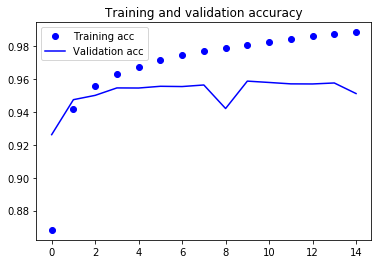

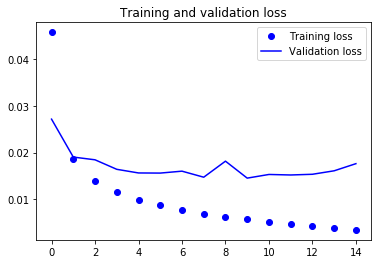

In [71]:
# Write your code here
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Apply your network to one sentence.

In [72]:
sentence = 'The United States might collapsez'.lower().split()

First convert the sentence into indices

In [85]:
# Write your code
print('Sentence', sentence)
sentence_idx=[[word2inx[x] if x in word2idx else 1 for x in sentence]]
print('Sentence word indexes', sentence_idx)

Sentence ['the', 'united', 'states', 'might', 'collapsez']
Sentence word indexes [[359698, 374678, 344404, 246008, 1]]


Apply the prediction

In [92]:
# Write your code
padded_sentence_idx=pad_sequences(sentence_idx, padding='post', maxlen=150)
preds_prob=model.predict(padded_sentence_idx)
preds=list(map(np.argmax,preds_prob[0][:5]))
print(preds)
for i, word in enumerate(sentence):
    print(word+':', idx2ner[preds[i]])



[10, 2, 6, 10, 10]
the: O
united: B-LOC
states: I-LOC
might: O
collapsez: O


## Evaluating your System

You will now evaluate the performance of your system on the whole test set. You will use the official script.
<ol>
    <li>Use the <tt>predict</tt> method to predict the tags of the whole test set
    </li>
    <li>Write your results in a file, where the two last columns will be the hand-annotated tag
        and the predicted tag. The fields must be separated by a space and each line must end with a new line:
        <tt>\n</tt>.
    </li>
    <li>
        If you save your results on a Windows machine, Python will use the default end-of-line sequence: <tt>\r\n</tt>.
        You will then need either to convert your file or to modify the way you save your file.
    </li>
    <li>Apply <tt>conlleval</tt> to your output. Report the F1 result.<br/>
        Be aware that <tt>conlleval</tt> was designed for Unix and will break
    with Windows end-of-line conventions.</li>
    <li>Try to improve your model by modifying some parameters, adding layers, adding
        <tt>Bidirectional</tt>
        and <tt>Dropout</tt>.
    </li>
    <li>
        Evaluate your network again
    </li>
</ol>

First translate the input part of the test set, the words, into lists of words, `X_test`, lists of indices, `X_test_idx`, and a matrix of indices, where you will pad the sequences: `X_test_padded`

In [98]:
# Test
X_test, Y_test = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test[1])
print('Y_test', Y_test[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']


In [99]:
# Write your code
X_test_idx=X_test.copy()
Y_test_idx=Y_test.copy()
for i, x in enumerate(X_test):
    for j, element in enumerate(x):
        if element in word2idx:
            X_test_idx[i][j]=word2idx[element]
        else:
            X_test_idx[i][j]=1
        
for i, y in enumerate(Y_test):
    for j, element in enumerate(y):
        if element in ner2idx:
            Y_test_idx[i][j]=ner2idx[element]
        else:
            Y_test_idx[i][j]=1
        
X_test_padded=pad_sequences(X_test_idx, padding='post', maxlen=150)
Y_test_padded=pad_sequences(Y_test_idx, padding='post', maxlen=150)

#y_dev= to_categorical(Y_dev, num_classes=len(ner)+2)

In [100]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded: [338644    679 197600 162137 229067 390518    517 100680 190291 350949
 120818    936      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

In [101]:
X_test_padded.shape

(3684, 150)

Now predict the whole test set with `predict` and set the results in `Y_test_hat`

In [103]:
# Write your code
Y_test_hat=model.predict(X_test_padded)

In [104]:
print('X_test', X_test[1])
print('X_test_padded', X_test_padded[1])
print('Predictions', Y_test_hat[0])

X_test [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded [338644    679 197600 162137 229067 390518    517 100680 190291 350949
 120818    936      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0    

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [106]:
# write your code
for i, sentence in enumerate(test_dict):
    preds=list(map(np.argmax,Y_test_hat[i]))
    for k, word in enumerate(sentence):
        word['pner']=idx2ner[preds[k]]
        
    

In [115]:
test_dict[1]

[{'form': 'SOCCER', 'ppos': 'NN', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '-', 'ppos': ':', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'JAPAN',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-LOC',
  'pner': 'B-LOC'},
 {'form': 'GET', 'ppos': 'VB', 'pchunk': 'B-VP', 'ner': 'O', 'pner': 'O'},
 {'form': 'LUCKY', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'WIN', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': ',', 'ppos': ',', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'},
 {'form': 'CHINA',
  'ppos': 'NNP',
  'pchunk': 'B-NP',
  'ner': 'B-PER',
  'pner': 'B-LOC'},
 {'form': 'IN', 'ppos': 'IN', 'pchunk': 'B-PP', 'ner': 'O', 'pner': 'O'},
 {'form': 'SURPRISE', 'ppos': 'DT', 'pchunk': 'B-NP', 'ner': 'O', 'pner': 'O'},
 {'form': 'DEFEAT', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O', 'pner': 'O'},
 {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O', 'pner': 'O'}]

In [108]:
ARCH = '1'
outfile = 'test' + ARCH + '.out'

In [109]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [110]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [112]:
save(outfile, test_dict, column_names)

In [117]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
baseline_score = res['overall']['chunks']['evals']['f1']
baseline_score

0.6513893324816353

## Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use <tt>Embedding</tt>, <tt>LSTM</tt>, and <tt>Dense</tt>.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding <tt>Bidirectional</tt>, <tt>Dropout</tt>, possibly mixing <tt>SimpleRNN</tt>.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [118]:
# Write your code
model =Sequential()
model.add(Embedding(len(vocabulary_words) + 2, 100, mask_zero=True, input_length=None)),
model.add(Dropout(0.2)),
model.add(Bidirectional(LSTM(100, return_sequences=True))),
model.add(Dropout(0.2)),
model.add(Dense(len(ner) + 2, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 11)          2211      
Total params: 40,422,711
Trainable params: 40,422,711
Non-trainable params: 0
_________________________________________________________________


Compile and fit it

In [55]:
# Write your code
model.complile()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          2010      
Total params: 40,422,510
Trainable params: 40,422,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
469/469 - 155s - loss: 0.0245 - acc: 0.9215 - val_loss: 0.0142 - val_acc: 0.9591
Epoch 2/15
469/4

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

In [119]:
# Write your code
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
history = model.fit(X, y_train, epochs=15, validation_data=(X_dev, y_dev), batch_size=128)

Epoch 1/15
118/118 [==============================] - 127s 1s/step - loss: 0.0431 - accuracy: 0.8724 - val_loss: 0.0277 - val_accuracy: 0.9242
Epoch 2/15
118/118 [==============================] - 158s 1s/step - loss: 0.0203 - accuracy: 0.9353 - val_loss: 0.0194 - val_accuracy: 0.9445
Epoch 3/15
118/118 [==============================] - 149s 1s/step - loss: 0.0148 - accuracy: 0.9530 - val_loss: 0.0133 - val_accuracy: 0.9629
Epoch 4/15
118/118 [==============================] - 150s 1s/step - loss: 0.0119 - accuracy: 0.9616 - val_loss: 0.0121 - val_accuracy: 0.9656
Epoch 5/15
118/118 [==============================] - 150s 1s/step - loss: 0.0102 - accuracy: 0.9668 - val_loss: 0.0120 - val_accuracy: 0.9658
Epoch 6/15
118/118 [==============================] - 175s 1s/step - loss: 0.0089 - accuracy: 0.9707 - val_loss: 0.0105 - val_accuracy: 0.9706
Epoch 7/15
118/118 [==============================] - 160s 1s/step - loss: 0.0079 - accuracy: 0.9740 - val_loss: 0.0101 - val_accuracy: 0.9713

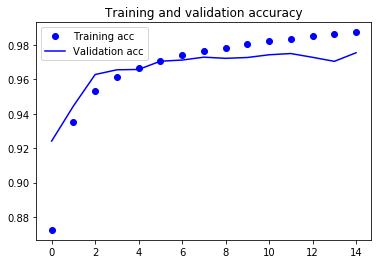

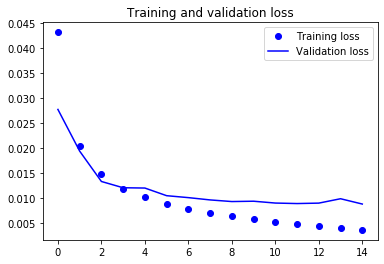

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Predict the NER sequence

In [121]:
# Write your code
Y_test_hat=model.predict(X_test_padded)      

Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [122]:
# write your code
for i, sentence in enumerate(test_dict):
    preds=list(map(np.argmax,Y_test_hat[i]))
    for k, word in enumerate(sentence):
        word['pner']=idx2ner[preds[k]]  

In [123]:
ARCH = '4'
outfile = 'test' + ARCH + '.out'

In [124]:
save(outfile, test_dict, column_names)

In [125]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
improved_score

0.8341805433829974

You need to reach 82 to pass the assignment.